In [24]:
# Author: Banafsheh Khazali, Emmett Collings
# Date: Oct 2, 2022

In [25]:
import networkx as nx # make sure you installed networkx
import numpy as np
import pandas as pd

In [26]:
# Graph with 2 edges per pairing
# Read in data
df = pd.read_csv("../../data/defense/defensemen_edgelist_corsi.csv")

# Create a network of nodes which are players and the links are players that played together
# We create 2 graphs, one for each relationship direction and then compose them for our total graph
df = df.rename(columns={'corsi_influence_on_player2_stdDevs':'weight'})
G0 = nx.Graph()
G0 = nx.from_pandas_edgelist(df, 'playerId1', 'playerId2', ['weight'],create_using=nx.DiGraph)

df = df.rename(columns={'weight':'notweight','corsi_influence_on_player1_stdDevs':'weight'})
G1 = nx.Graph()
G1 = nx.from_pandas_edgelist(df, 'playerId2', 'playerId1', edge_attr='weight',create_using=nx.DiGraph)

G = nx.compose(G0, G1)

# Add player names to nodes
players_df = pd.read_csv("../../data/defense/aggregate_defensemen.csv", index_col='playerId', header=0)
player_names = dict.fromkeys(G.nodes)
for player in G.nodes:
    player_name = players_df.loc[[player]]["playerName"].values[0]
    player_names[player] = player_name

nx.set_node_attributes(G, player_names, "playerName")

# output a gephi file for ez visualization
nx.write_gexf(G, 'defense.gexf')


# Basic Statistics


In [27]:
# Number of nodes and edges
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print("Number of nodes: ", num_nodes)
print("Number of edges: ", num_edges)

# Average outgoing link weight. This determines which players had the greatest effect on their linemates
# Do total out degree as well
out_degrees = G.out_degree(weight="weight")
for player_out_degree in out_degrees:
    player_id = player_out_degree[0]
    avg_out_weight = player_out_degree[1] / G.out_degree(player_id)
    players_df.loc[player_id, "average_corsi_influence"] = avg_out_weight
    players_df.loc[player_id, "total_out_influence"] = player_out_degree[1]

output_file = '../../data/defense/aggregate_defensemen.csv'
players_df.to_csv(output_file)

# Outgoing link weight correlations
print(players_df.corr(numeric_only=True))
players_df.corr(numeric_only=True, method='spearman').to_csv("../../data/defense/correlations.csv")



Number of nodes:  550
Number of edges:  4452
                                     games_played   icetime    shifts  \
games_played                             1.000000  0.993911  0.686480   
icetime                                  0.993911  1.000000  0.691111   
shifts                                   0.686480  0.691111  1.000000   
gameScore                                0.580064  0.604582  0.772929   
onIce_xGoalsPercentage                   0.113626  0.115094  0.153666   
...                                           ...       ...       ...   
I_F_dZoneShiftStarts_per_game            0.526747  0.540644  0.508243   
I_F_neutralZoneShiftStarts_per_game      0.558116  0.579634  0.524163   
I_F_flyShiftStarts_per_game              0.343366  0.348978  0.386908   
average_corsi_influence                  0.133208  0.138285  0.076386   
total_out_influence                      0.137653  0.153193  0.126949   

                                     gameScore  onIce_xGoalsPercentage  \
game

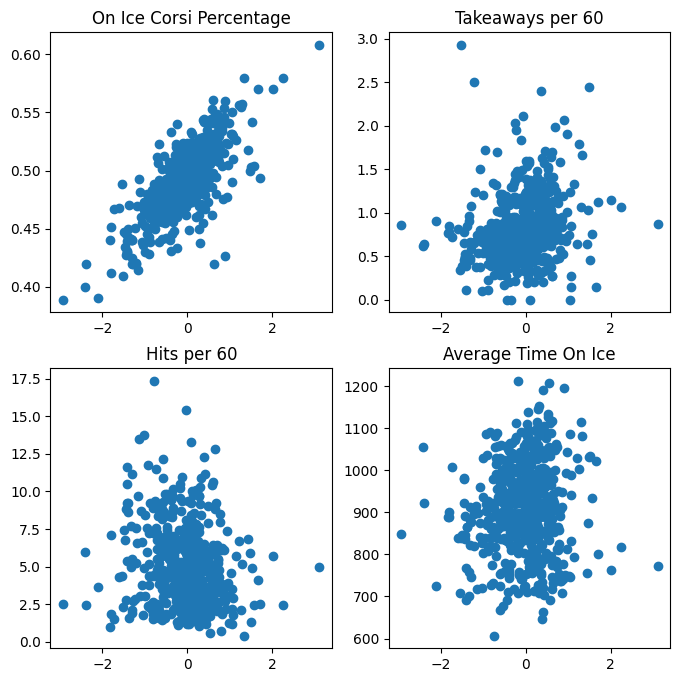

In [28]:
import matplotlib.pyplot as plt
# Chart some stats vs avg corsi influence
fig, axs = plt.subplots(2,2)
fig.set_size_inches(8, 8)
axs[0,0].scatter(players_df['average_corsi_influence'], players_df['onIce_corsiPercentage'])
axs[0,0].set_title("On Ice Corsi Percentage")
axs[0,1].scatter(players_df['average_corsi_influence'], players_df['I_F_takeaways_per60'])
axs[0,1].set_title("Takeaways per 60")
axs[1,0].scatter(players_df['average_corsi_influence'], players_df['I_F_hits_per60'])
axs[1,0].set_title("Hits per 60")
axs[1,1].scatter(players_df['average_corsi_influence'], players_df['average_TOI'])
axs[1,1].set_title("Average Time On Ice")
plt.show()


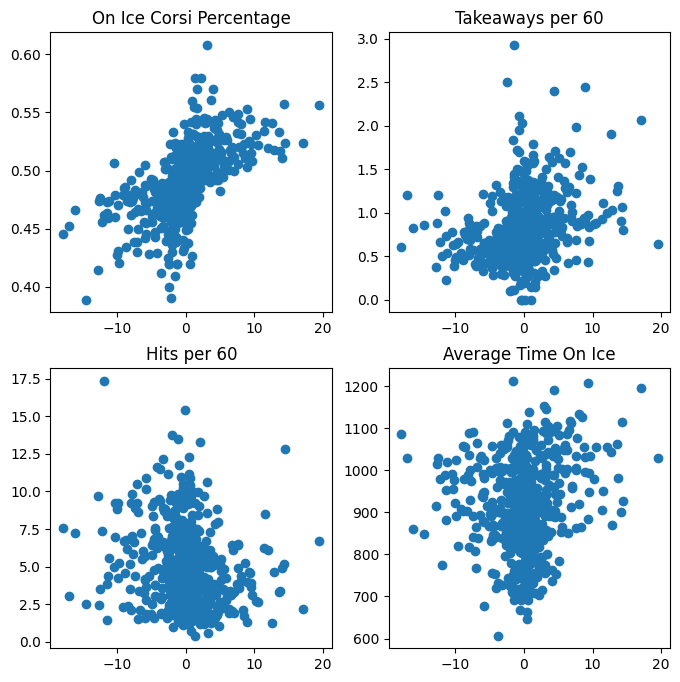

In [29]:
# Chart some stats vs total out degree
fig, axs = plt.subplots(2,2)
fig.set_size_inches(8, 8)
axs[0,0].scatter(players_df['total_out_influence'], players_df['onIce_corsiPercentage'])
axs[0,0].set_title("On Ice Corsi Percentage")
axs[0,1].scatter(players_df['total_out_influence'], players_df['I_F_takeaways_per60'])
axs[0,1].set_title("Takeaways per 60")
axs[1,0].scatter(players_df['total_out_influence'], players_df['I_F_hits_per60'])
axs[1,0].set_title("Hits per 60")
axs[1,1].scatter(players_df['total_out_influence'], players_df['average_TOI'])
axs[1,1].set_title("Average Time On Ice")
plt.show()

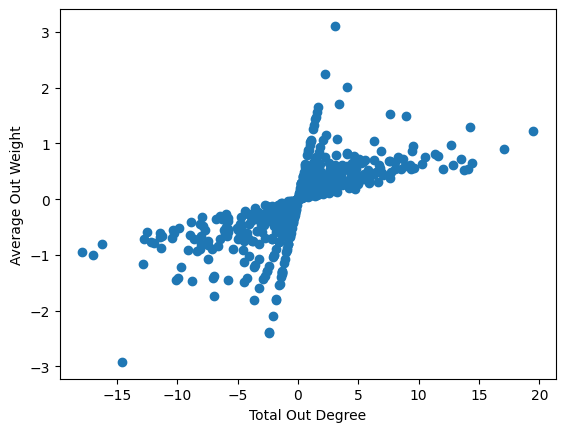

In [30]:
# Average influence vs total influence
fig = plt.subplot()
fig.scatter(players_df["total_out_influence"], players_df["average_corsi_influence"])
plt.xlabel("Total Out Degree")
plt.ylabel("Average Out Weight")
plt.show()

In [31]:
# Number of connected components
is_strongly_connected = nx.is_strongly_connected(G)
print("Is graph strongly connected? ", is_strongly_connected)
num_strongly_connected_components = nx.number_strongly_connected_components(G)
print("Number of strongly connected components: ", num_strongly_connected_components)

Is graph strongly connected?  False
Number of strongly connected components:  2


In [32]:
# Path length
for C in (G.subgraph(c).copy() for c in nx.weakly_connected_components(G)):
    print(nx.average_shortest_path_length(C))

3.5132974819519878
1.0


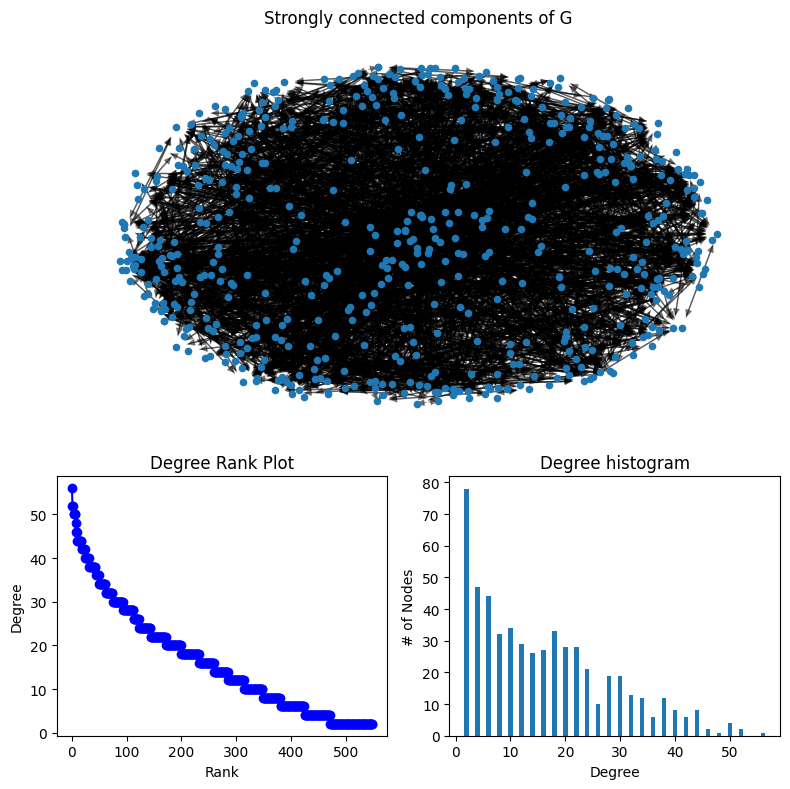

In [33]:
# Degree distribution
import matplotlib.pyplot as plt
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = G.subgraph(sorted(nx.strongly_connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Strongly connected components of G")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()


In [34]:
# Clustering coefficient
clustering_coefficients = nx.clustering(G)
# print("Clustering coefficient: ", clustering_coefficients)
average_clustering = nx.average_clustering(G)
print("Average clustering coefficient: ", average_clustering)


Average clustering coefficient:  0.26636734680272417


In [35]:
print(nx.is_weakly_connected(G))

False


# Centrality Measures

In [36]:
# Degree centrality
degree_centrality = nx.degree_centrality(G)
# print("Degree centrality: ", degree_centrality)
in_degree_centrality = nx.in_degree_centrality(G)
# print("In degree centrality: ", in_degree_centrality)
out_degree_centrality = nx.out_degree_centrality(G)
# print("Out degree centrality: ", out_degree_centrality)

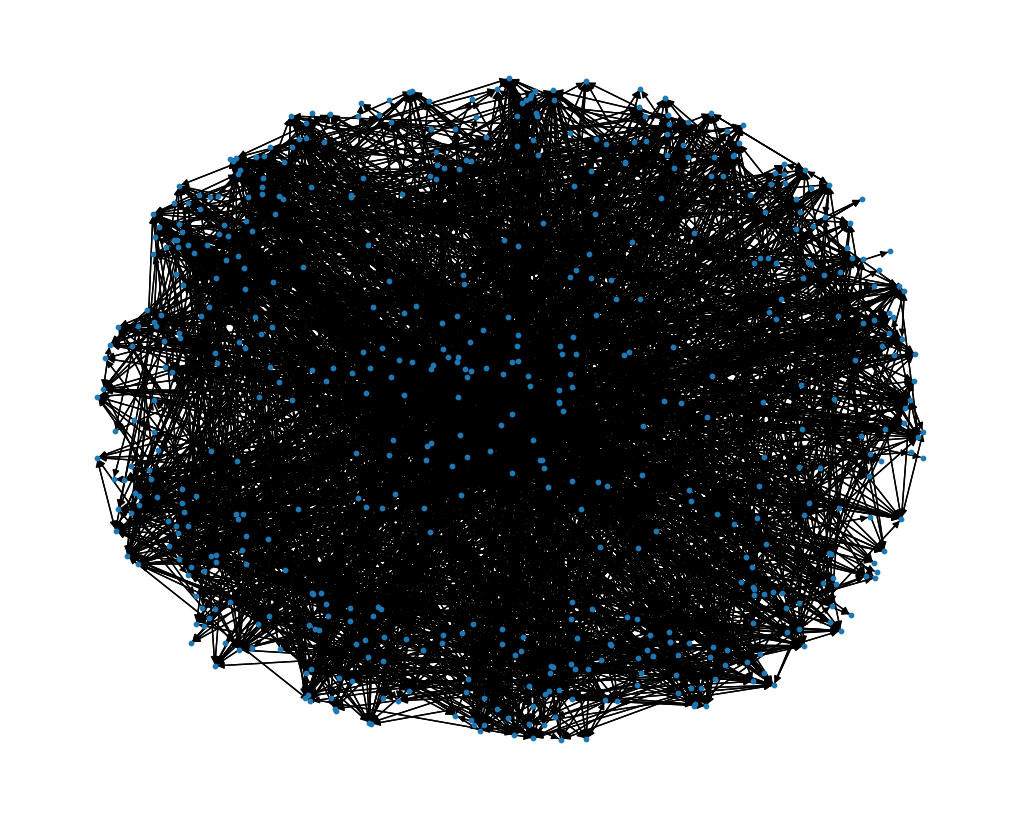

In [37]:
# Plot the network
from matplotlib.pyplot import figure
figure(figsize=(10, 8))
nx.draw_spring(G, node_size=10)

In [38]:
# number of edges
G.number_of_edges()


4452

In [39]:
# number of nodes
G.number_of_nodes()

550

In [40]:
#basic analysis
N = len(G)
L = G.size()
degrees = [G.degree(node) for node in G]
kmin = min(degrees)
kmax = max(degrees)

In [41]:
print("Number of nodes: ", N)
print("Number of edges: ", L)
print()
print("Average degree: ", 2*L/N)
print("Average degree (alternate calculation)", np.mean(degrees))
print()
print("Minimum degree: ", kmin)
print("Maximum degree: ", kmax)

Number of nodes:  550
Number of edges:  4452

Average degree:  16.189090909090908
Average degree (alternate calculation) 16.189090909090908

Minimum degree:  2
Maximum degree:  56


In [42]:
# Get 10 logarithmically spaced bins between kmin and kmax
bin_edges = np.logspace(np.log10(kmin), np.log10(kmax), num=10)

# histogram the data into these bins
density, _ = np.histogram(degrees, bins=bin_edges, density=True)


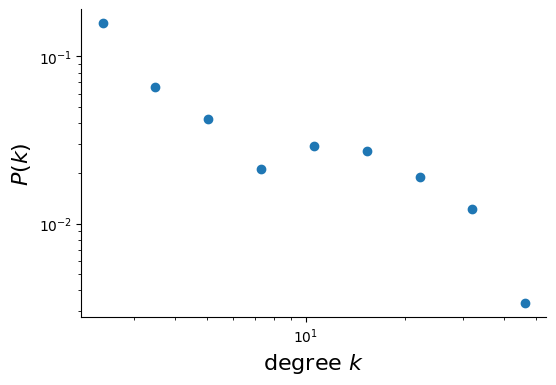

In [43]:
fig = plt.figure(figsize=(6,4))

# "x" should be midpoint (IN LOG SPACE) of each bin
log_be = np.log10(bin_edges)
x = 10**((log_be[1:] + log_be[:-1])/2)

plt.loglog(x, density, marker='o', linestyle='none')
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$P(k)$", fontsize=16)

# remove right and top boundaries because they're ugly
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# Show the plot
plt.show()

In [44]:
# Get 20 logarithmically spaced bins between kmin and kmax
bin_edges = np.linspace(kmin, 10, num=10)

# histogram the data into these bins
density, _ = np.histogram(degrees, bins=bin_edges, density=True)

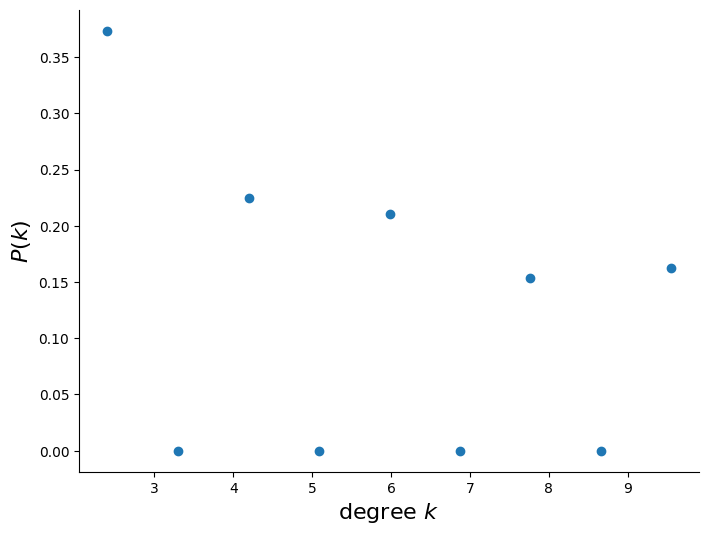

In [45]:
fig = plt.figure(figsize=(8,6))

# "x" should be midpoint (IN LOG SPACE) of each bin
log_be = np.log10(bin_edges)
x = 10**((log_be[1:] + log_be[:-1])/2)

plt.plot(x, density, marker='o', linestyle='none')
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$P(k)$", fontsize=16)

# remove right and top boundaries because they're ugly
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# Show the plot
plt.show()

In [46]:
print(nx.info(G))

DiGraph with 550 nodes and 4452 edges


/tmp/ipykernel_15994/2606185536.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


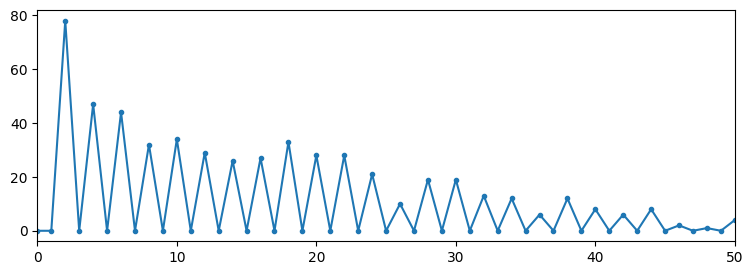

In [47]:
hist = nx.degree_histogram(G)
plt.figure(figsize=(9,3))
plt.plot(hist, marker = '.')
plt.xlim((0,50))
plt.show()

In [48]:
def all_networks(g, start, end):
    def plotpath(g, path):
        h = nx.subgraph(g, path)               
        nx.draw(h, pos = pos, node_color = 'r', edge_color = 'r', 
                node_size = 100, aplha = 0.7, width = 2)

    paths = nx.all_shortest_paths(g, source = start, target = end)
    paths = [i for i in paths]
    h = nx.subgraph(g, sum([i for i in paths], []))    
    labels = nx.get_node_attributes(h, 'label')   
    i = nx.subgraph(g, sum([nx.neighbors(g, i) for i in h.nodes()], []))  
    pos = nx.fruchterman_reingold_layout(i)
    
    plt.figure(figsize=(9,6))
    nx.draw(i, pos = pos, node_color = 'b', edge_color = 'b', node_size = 50, alpha = 0.5)
    [plotpath(g, i) for i in paths]
    nx.draw_networkx_labels(i, pos = pos, labels = labels, font_size = 10)
    plt.show()

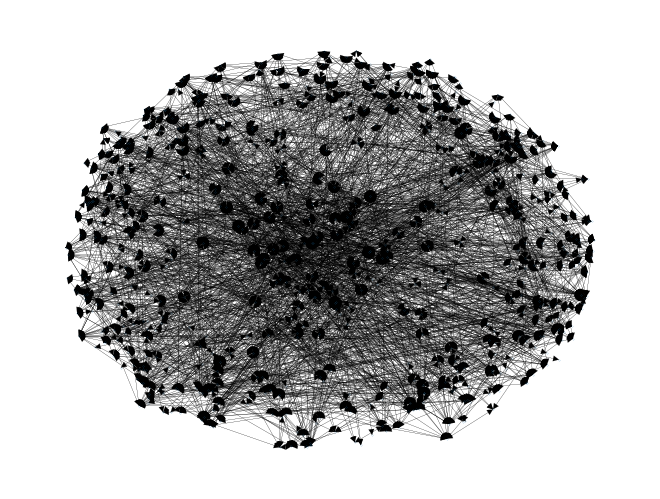

In [49]:
nx.draw(G, pos=nx.spring_layout(G), node_size=0.01, width=0.1)


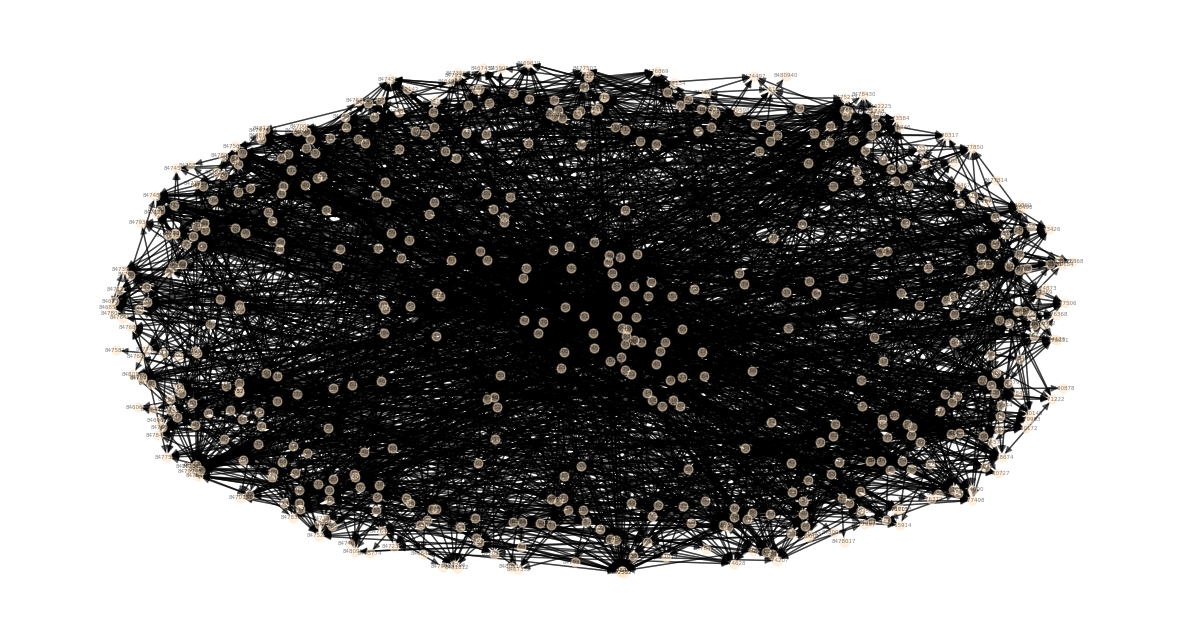

In [50]:
fig, ax = plt.subplots(figsize=(15, 8))

nx.draw_spring(G, node_color='bisque', with_labels=True , node_size = 40 , font_size = 4 , alpha = 0.5)